# Notebook 02: Modelo de Riesgo (GPD) y Stock de Seguridad
## Objetivo: Calcular el stock de seguridad óptimo basándonos en los errores (residuos) del modelo core (GBR).

## Metodología:

- Cargar los resultados de validación (reales vs. predicción) del 01-model_core.ipynb.

- Calcular los residuos (Error = Real - Predicción).

- Aislar los residuos positivos (quiebres de stock) y definir un umbral (Cuantil 90%).

- Ajustar un modelo de Distribución Generalizada de Pareto (GPD) a los "excesos" (errores por encima del umbral).

- Calcular el stock de seguridad necesario para un Nivel de Servicio objetivo (ej. 98%).

## 0. Configuración e Importación

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import genpareto

# Configuración de visualización
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

## 1. Carga de Datos (Resultados del Modelo Core)
Cargamos el archivo .csv que generó el notebook 01-model_core.ipynb y que guardamos en la carpeta data/interim/.

In [2]:
# Cargar los resultados del notebook anterior
path_datos = '../data/interim/model_core_validation.csv'
val_comparativo = pd.read_csv(path_datos)

print("Datos de validación (input) cargados:")
print(f"Filas cargadas: {len(val_comparativo)}")
print(val_comparativo.head())

Datos de validación (input) cargados:
Filas cargadas: 7620
        fecha  prod_id  precio_promedio  ventas  modelo_actual  year  month  \
0  2023-01-01        0      5718.490738  2447.0    1662.504452  2023      1   
1  2023-02-01        0      6718.343539  1565.0    1692.611786  2023      2   
2  2023-03-01        0      5742.707352   786.0    1545.866974  2023      3   
3  2023-04-01        0      5267.384648   775.0    1340.509092  2023      4   
4  2023-05-01        0      4020.565431  1063.0    1138.194231  2023      5   

   lag_12  lag_13  lag_24  rolling_mean_3_lag12  precio_lag_12     pred_gbr  
0  2121.0  1019.0  4488.0           1410.000000    4085.525083  2111.058526  
1   924.0  2121.0  1512.0           1354.666667    6603.793792  1230.176206  
2  1678.0   924.0  1379.0           1574.333333    3723.599803  1247.068278  
3   565.0  1678.0  1457.0           1055.666667    6393.080571  1090.714359  
4   559.0   565.0  1178.0            934.000000    5802.376341   924.195118 

## 2. Calcular y Analizar Residuos
Calculamos el error de nuestro modelo core. Residuo = Venta_Real - Predicción_GBR

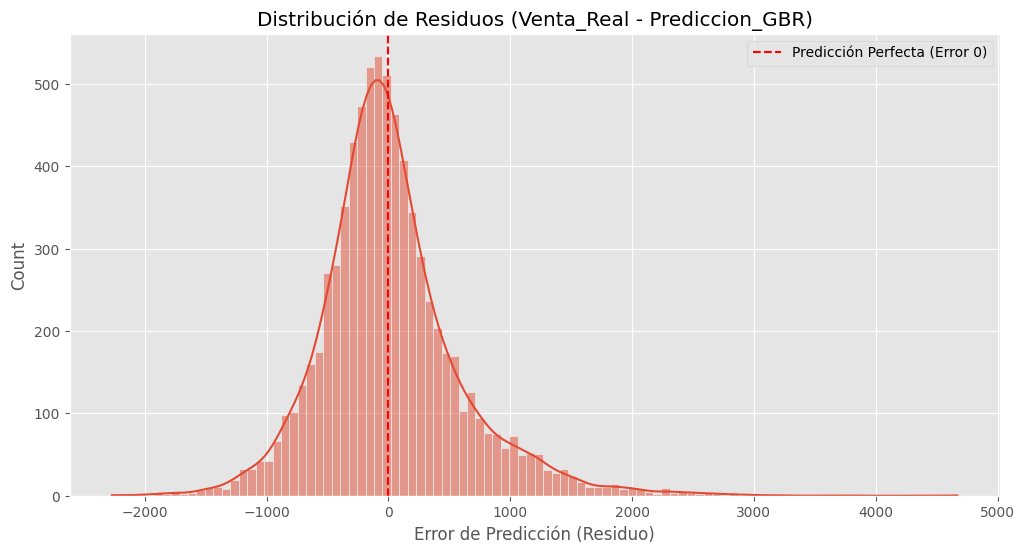

   ventas     pred_gbr     residuo
0  2447.0  2111.058526  335.941474
1  1565.0  1230.176206  334.823794
2   786.0  1247.068278 -461.068278
3   775.0  1090.714359 -315.714359
4  1063.0   924.195118  138.804882


In [3]:
# Calcular residuos
val_comparativo['residuo'] = val_comparativo['ventas'] - val_comparativo['pred_gbr']

# Graficar la distribución de los residuos
plt.figure(figsize=(12, 6))
sns.histplot(val_comparativo['residuo'], kde=True, bins=100)
plt.title('Distribución de Residuos (Venta_Real - Prediccion_GBR)')
plt.xlabel('Error de Predicción (Residuo)')
plt.axvline(0, color='red', linestyle='--', label='Predicción Perfecta (Error 0)')
plt.legend()
plt.show()

# Vistazo a los residuos
print(val_comparativo[['ventas', 'pred_gbr', 'residuo']].head())

Observación: Nos interesa la cola positiva (residuo > 0), que son los escenarios donde subestimamos la demanda (quiebre de stock).

## 3. Definir Umbral (Threshold) y Aislar Excesos
Nos enfocamos solo en la cola positiva (residuo > 0).

Definimos un umbral u (usaremos el Cuantil 90% de los errores positivos). El modelo GPD analizará todos los errores que estén por encima de este umbral.

Residuos positivos (quiebres de stock) analizados: 3442
Umbral (u) seleccionado (Cuantil 90.0%): 1142.95 unidades
Número de 'excesos' para ajustar GPD: 345


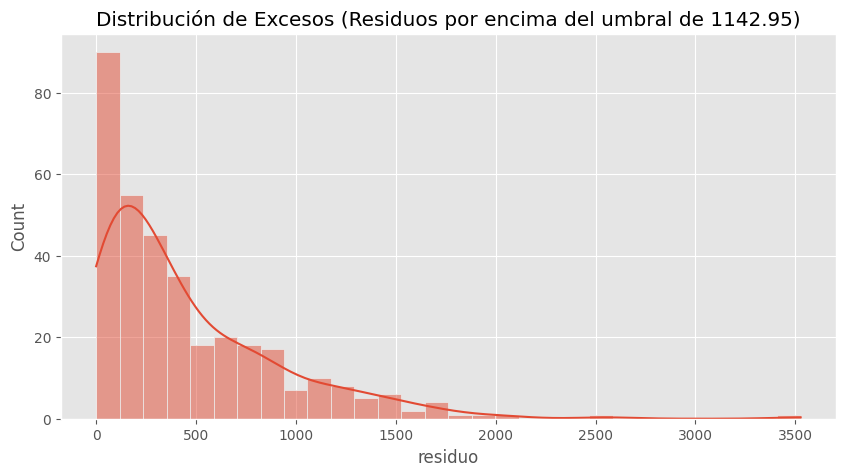

In [4]:
# 1. Aislar solo los residuos positivos (donde subestimamos)
residuos_pos = val_comparativo[val_comparativo['residuo'] > 0]['residuo']

if residuos_pos.empty:
    print("No se encontraron residuos positivos. El modelo nunca subestima la demanda.")
    # (En un escenario real, esto es casi imposible y deberías revisar el modelo)
else:
    # 2. Definir el umbral (u)
    # Usaremos el cuantil 90% de los residuos positivos.
    CUANTIL_UMBRAL = 0.90
    umbral = residuos_pos.quantile(CUANTIL_UMBRAL)

    # 3. Calcular los "excesos" (cuánto se pasó del umbral)
    excesos = residuos_pos[residuos_pos > umbral] - umbral

    print(f"Residuos positivos (quiebres de stock) analizados: {len(residuos_pos)}")
    print(f"Umbral (u) seleccionado (Cuantil {CUANTIL_UMBRAL*100}%): {umbral:.2f} unidades")
    print(f"Número de 'excesos' para ajustar GPD: {len(excesos)}")

    # Graficar los excesos
    plt.figure(figsize=(10, 5))
    sns.histplot(excesos, kde=True, bins=30)
    plt.title(f'Distribución de Excesos (Residuos por encima del umbral de {umbral:.2f})')
    plt.show()

## 4. Ajustar el Modelo GPD
Alimentamos los "excesos" a scipy.stats.genpareto para que encuentre los parámetros (c, loc, scale) de la distribución de la cola.

In [5]:
# Ajustar el modelo GPD
# c = shape (forma), loc = location (ubicación), scale = scale (escala)
# El parámetro 'c' (shape) es el más importante.

# Usamos 'floc=0' para fijar el location en 0, ya que los excesos empiezan en 0.
c, loc, scale = genpareto.fit(excesos, floc=0) 

print(f"Parámetros GPD ajustados (c, loc, scale): ({c:.3f}, {loc:.3f}, {scale:.3f})")

if c > 0:
    print(f"El parámetro 'c' (shape) es {c:.3f} (positivo):")
    print("==> La cola es 'pesada' (heavy-tailed). El riesgo de eventos extremos es significativo.")
else:
    print(f"El parámetro 'c' (shape) es {c:.3f} (negativo/cero):")
    print("==> La cola es 'ligera'. El riesgo de eventos extremos es bajo.")

Parámetros GPD ajustados (c, loc, scale): (0.029, 0.000, 446.322)
El parámetro 'c' (shape) es 0.029 (positivo):
==> La cola es 'pesada' (heavy-tailed). El riesgo de eventos extremos es significativo.


## 5. Calcular el Stock de Seguridad (Valor de Negocio)

Usamos los parámetros GPD para calcular el valor exacto necesario para alcanzar nuestro Nivel de Servicio (NS) objetivo (ej. 98%).

El Stock de Seguridad se compone del umbral (u) + el valor extra (stock_extra_gpd) que nos da el modelo GPD.

Stock_Total_Recomendado = Pronóstico_GBR + Stock_de_Seguridad

In [6]:
# Nivel de servicio objetivo (cuánta demanda queremos cubrir)
NIVEL_SERVICIO_OBJETIVO = 0.98

# --- Cálculo ---

# 1. Probabilidad de estar por encima del umbral (ya la sabemos)
prob_sobre_umbral = 1 - CUANTIL_UMBRAL  # (1 - 0.90 = 0.10)

# 2. Probabilidad que necesitamos buscar DENTRO del modelo GPD
# (Nivel de servicio deseado - Nivel de servicio del umbral) / Probabilidad de estar en la cola
prob_gpd = (NIVEL_SERVICIO_OBJETIVO - CUANTIL_UMBRAL) / (1 - CUANTIL_UMBRAL)

# Asegurarnos que la probabilidad esté entre 0 y 1
if not 0 <= prob_gpd <= 1:
    print(f"Error: El Nivel de Servicio Objetivo ({NIVEL_SERVICIO_OBJETIVO*100}%) está por debajo")
    print(f"del cuantil del umbral ({CUANTIL_UMBRAL*100}%). No se necesita GPD.")
    stock_extra_gpd = 0
else:
    print(f"Probabilidad de GPD requerida para alcanzar {NIVEL_SERVICIO_OBJETIVO*100}% NS: {prob_gpd:.2%}")
    # 3. Calcular el valor extra usando la PPF (Percent Point Function)
    # Esta es la inversa de la CDF: le damos una probabilidad, nos da un valor.
    stock_extra_gpod = genpareto.ppf(prob_gpd, c, loc=loc, scale=scale)


# 4. Calcular el Stock de Seguridad TOTAL
# Es la suma del umbral + el valor extra de GPD
stock_de_seguridad_total = umbral + stock_extra_gpod

print("\n--- RESULTADO FINAL ---")
print(f"Para un Nivel de Servicio del {NIVEL_SERVICIO_OBJETIVO*100}%:")
print(f"El Stock de Seguridad TOTAL requerido (adicional al pronóstico GBR) es: {stock_de_seguridad_total:.0f} unidades")

print("\n--- EJEMPLO DE DECISIÓN DE NEGOCIO ---")
pronostico_ejemplo = 1000
stock_total_recomendado = pronostico_ejemplo + stock_de_seguridad_total
print(f"Si el modelo GBR predice {pronostico_ejemplo} unidades...")
print(f"Para cubrir el {NIVEL_SERVICIO_OBJETIVO*100}% de la demanda: se debe planificar un stock de {stock_total_recomendado:.0f} unidades.")

Probabilidad de GPD requerida para alcanzar 98.0% NS: 80.00%

--- RESULTADO FINAL ---
Para un Nivel de Servicio del 98.0%:
El Stock de Seguridad TOTAL requerido (adicional al pronóstico GBR) es: 1878 unidades

--- EJEMPLO DE DECISIÓN DE NEGOCIO ---
Si el modelo GBR predice 1000 unidades...
Para cubrir el 98.0% de la demanda: se debe planificar un stock de 2878 unidades.


## 6. Próximos Pasos
Este notebook ha calculado el stock de seguridad global.

El siguiente paso es 03-model_inference.ipynb, que re-entrenará el modelo core con todos los datos y generará el pronóstico final para 2024. Al combinar ese pronóstico con este cálculo de stock de seguridad, el negocio tiene una política de inventario completa.